In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import joblib
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    RocCurveDisplay
)
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Загрузка
df = pd.read_csv("S06-hw-dataset-01.csv")

# Базовая информация
print(df.head())
print("\n--- Info ---")
print(df.info())
print("\n--- Describe ---")
print(df.describe())

# Распределение таргета
target_counts = df['target'].value_counts(normalize=True)
print("\n--- Target distribution ---")
print(target_counts)

# Проверка пропусков
print("\n--- Missing values ---")
print(df.isnull().sum().sum())  # должно быть 0

# Разделение
X = df.drop(columns=['id', 'target'])
y = df['target']

   id     num01     num02     num03     num04     num05     num06     num07  \
0   1 -0.946058 -0.070313  1.824445 -2.754422  0.808865 -0.111094 -0.268950   
1   2 -2.484027  0.739378  1.596908 -2.586479 -0.033225 -3.054412 -4.706908   
2   3  1.522629  7.159635 -0.564903 -4.493110  1.623610  5.450187 -0.974595   
3   4  0.463373 -1.073908  1.752813  0.362786  2.790872  4.082385  0.322283   
4   5  3.188390 -4.701692 -0.689918 -0.448995  0.373821 -3.275363 -1.760931   

      num08     num09  ...     num20     num21     num22     num23     num24  \
0 -3.078210  0.801275  ... -1.616515 -1.989464  1.407390 -0.218362  2.016052   
1 -9.795169  0.145911  ... -1.727040 -0.583997  1.136761  0.285978 -0.310879   
2 -5.189589  1.600591  ...  0.524408  2.022430  1.278358 -0.850547  0.847457   
3  3.390984 -0.033929  ...  2.399834 -1.431576 -0.746987  0.049639  2.414689   
4  0.923689  0.537345  ... -2.183407 -2.896590  2.440343 -1.097168  1.457323   

   cat_contract  cat_region  cat_payment  te

In [16]:
# Фиксированный сплит
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Фиксированный random_state обеспечивает воспроизводимость. \
Stratify=y сохраняет пропорции классов в train и test.

In [7]:
# Dummy
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

# Logistic Regression
lr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(random_state=42, max_iter=1000))
])
lr_pipe.fit(X_train, y_train)
y_pred_lr = lr_pipe.predict(X_test)

# Метрики baseline
def compute_metrics(y_true, y_pred, y_proba=None):
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
    }
    if y_proba is not None:
        metrics['roc_auc'] = roc_auc_score(y_true, y_proba)
    return metrics

baseline_metrics = {
    'Dummy': compute_metrics(y_test, y_pred_dummy),
    'LogisticRegression': compute_metrics(y_test, y_pred_lr, lr_pipe.predict_proba(X_test)[:, 1])
}

baseline_metrics

{'Dummy': {'accuracy': 0.6766666666666666, 'f1': 0.0},
 'LogisticRegression': {'accuracy': 0.8275,
  'f1': 0.7076271186440678,
  'roc_auc': 0.8746905312071505}}

In [10]:
# 1. Decision Tree с контролем сложности
dt = DecisionTreeClassifier(random_state=42)
dt_params = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_leaf': [5, 10, 20]
}
dt_cv = GridSearchCV(dt, dt_params, cv=5, scoring='f1')
dt_cv.fit(X_train, y_train)

# 2. Random Forest
rf = RandomForestClassifier(random_state=42)
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'min_samples_leaf': [5, 10]
}
rf_cv = GridSearchCV(rf, rf_params, cv=5, scoring='f1')
rf_cv.fit(X_train, y_train)

# 3. Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb_params = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}
gb_cv = GridSearchCV(gb, gb_params, cv=5, scoring='f1')
gb_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [50, 100]},
             scoring='f1')

In [11]:
models = {
    'DecisionTree': dt_cv,
    'RandomForest': rf_cv,
    'GradientBoosting': gb_cv
}

all_metrics = baseline_metrics.copy()
search_summaries = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    all_metrics[name] = compute_metrics(y_test, y_pred, y_proba)
    
    # Сохраняем лучшие параметры и CV score
    search_summaries[name] = {
        'best_params': model.best_params_,
        'best_cv_score': float(model.best_score_)
    }

# Найдём лучшую модель по ROC-AUC
best_model_name = max(all_metrics.keys(), key=lambda k: all_metrics[k].get('roc_auc', -1))
best_model = models[best_model_name]

all_metrics

{'Dummy': {'accuracy': 0.6766666666666666, 'f1': 0.0},
 'LogisticRegression': {'accuracy': 0.8275,
  'f1': 0.7076271186440678,
  'roc_auc': 0.8746905312071505},
 'DecisionTree': {'accuracy': 0.8720833333333333,
  'f1': 0.7924273157538878,
  'roc_auc': 0.8950488167182977},
 'RandomForest': {'accuracy': 0.9116666666666666,
  'f1': 0.8519553072625698,
  'roc_auc': 0.9600459918236757},
 'GradientBoosting': {'accuracy': 0.9191666666666667,
  'f1': 0.8685636856368564,
  'roc_auc': 0.9635850451983138}}

In [12]:
# Создаём папку
artifacts_dir = Path("artifacts")
figures_dir = artifacts_dir / "figures"
artifacts_dir.mkdir(exist_ok=True)
figures_dir.mkdir(exist_ok=True)

# 1. metrics_test.json
with open(artifacts_dir / "metrics_test.json", "w") as f:
    json.dump(all_metrics, f, indent=2)

# 2. search_summaries.json
with open(artifacts_dir / "search_summaries.json", "w") as f:
    json.dump(search_summaries, f, indent=2)

# 3. best_model.joblib
joblib.dump(best_model, artifacts_dir / "best_model.joblib")

# 4. best_model_meta.json
best_meta = {
    "best_model": best_model_name,
    "params": best_model.best_params_,
    "test_metrics": all_metrics[best_model_name]
}
with open(artifacts_dir / "best_model_meta.json", "w") as f:
    json.dump(best_meta, f, indent=2)

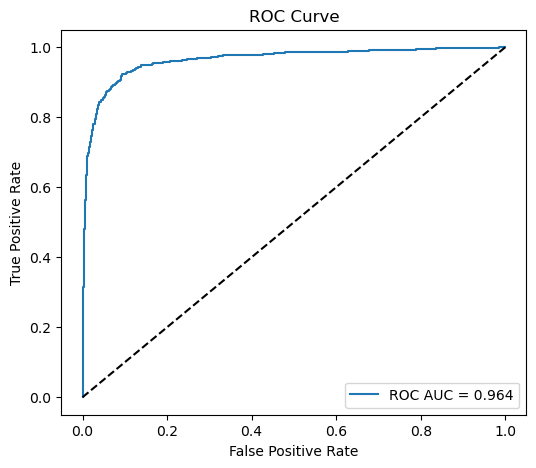

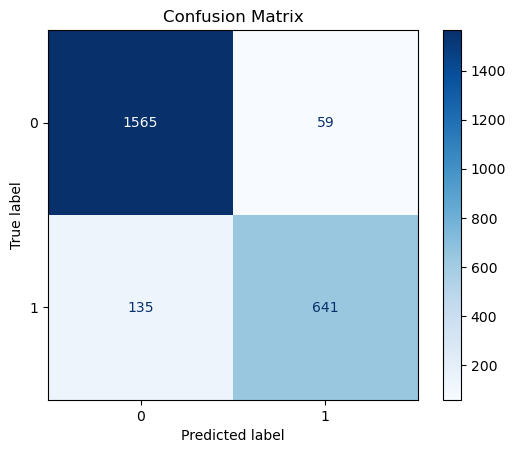

In [13]:
# ROC curve
y_proba_best = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba_best)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC AUC = {all_metrics[best_model_name]['roc_auc']:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.savefig(figures_dir / "roc_curve.png", dpi=150, bbox_inches='tight')
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, best_model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig(figures_dir / "confusion_matrix.png", dpi=150, bbox_inches='tight')
plt.show()

In [14]:
# Вычисляем важность признаков
perm_imp = permutation_importance(
    best_model, X_test, y_test, n_repeats=10, random_state=42, scoring='f1'
)

# Топ-10
indices = np.argsort(perm_imp.importances_mean)[::-1][:10]
top_features = X.columns[indices]
top_importances = perm_imp.importances_mean[indices]

print("Top 10 important features:")
for i, (feat, imp) in enumerate(zip(top_features, top_importances)):
    print(f"{i+1}. {feat}: {imp:.4f}")

Top 10 important features:
1. num19: 0.1645
2. num18: 0.1441
3. num07: 0.0883
4. num04: 0.0418
5. num24: 0.0350
6. num20: 0.0258
7. num21: 0.0241
8. num22: 0.0208
9. num16: 0.0175
10. num17: 0.0174


### Интерпретация лучшей модели: Permutation Importance

Для лучшей модели (`GradientBoostingClassifier`) была вычислена важность признаков методом перестановок (permutation importance) на тестовой выборке. Топ-10 наиболее влиятельных признаков:

1. `num19`: 0.1645  
2. `num18`: 0.1441  
3. `num07`: 0.0883  
4. `num04`: 0.0418  
5. `num24`: 0.0350  
6. `num20`: 0.0258  
7. `num21`: 0.0241  
8. `num22`: 0.0208  
9. `num16`: 0.0175  
10. `num17`: 0.0174  

Признаки `num18` и `num19` оказывают наибольшее влияние на качество предсказаний — их случайное перемешивание приводит к существенному падению F1-меры. Это согласуется с генерацией данных: последние признаки (`num16`–`num24`) имитируют категориальные переменные с небольшим числом уникальных значений, которые деревья обрабатывают особенно эффективно.